In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir(r'/content')  # Change the directory to torchRay-master folder

# Requirements

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

# Dataset loader

In [4]:
train_dir = '/content/drive/My Drive/project_a_supp/hmt_dataset/HMT_train'
test_dir = '/content/drive/My Drive/project_a_supp/hmt_dataset/HMT_test'

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [5]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten?

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
#model.add(Dense(1024, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
#                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0

# Training

In [7]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

In [8]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log2', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [ ]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    epochs=150,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)

In [ ]:
model.save('HMT.h5')

# Load Model

In [8]:
model=load_model('HMT.h5')

In [ ]:
def my_summary_iterator(path):
  for r in tf_record.tf_record_iterator(path):
    yield event_pb2.Event.FromString(r)
train_acc = []
train_loss = []
train_lr = []
#print('log/train/' + os.listdir('log/train')[2])
for e in my_summary_iterator('log/train/' + os.listdir('log/train')[-1]):
  for v in e.summary.value:
    if v.tag == 'epoch_accuracy':
      train_acc.append(v.simple_value)
    elif v.tag == 'epoch_loss':
      train_loss.append(v.simple_value)

Text(0.5, 1.0, 'Training progress: Accuracy')

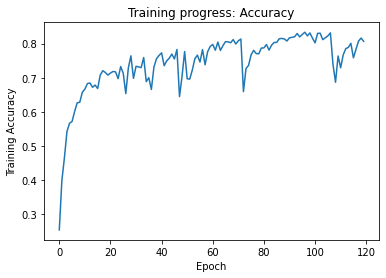

In [ ]:
plt.plot(np.arange(len(train_acc)), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training progress: Accuracy')

Text(0.5, 1.0, 'Training progress: Loss')

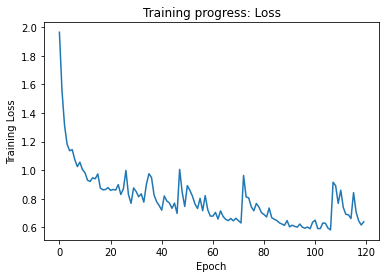

In [ ]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training progress: Loss')

# Explanation

Load the explaier library

In [9]:
from xai_utils import *

Load a batch of images

In [10]:
test_generator.reset()

In [11]:
image_batch,label_batch=test_generator.next()

Classes:

In [12]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

Predict a single image

In [13]:
index=8

In [14]:
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.9661708


Generate explanation map

## SISE (Semantic Input Sampling for Explanation)

Set the layer(s)

In [15]:
layers=[['conv2d_3']]

In [16]:
%%time
explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
explanation_map_SISE -= explanation_map_SISE.min()
explanation_map_SISE /= explanation_map_SISE.max()+10e-30

CPU times: user 361 ms, sys: 249 ms, total: 609 ms
Wall time: 628 ms


## Grad-CAM (Gradient-based Class Activation Mapping)

In [17]:
%%time
explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
explanation_map_GradCAM -= explanation_map_GradCAM.min()
explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

CPU times: user 168 ms, sys: 35.8 ms, total: 204 ms
Wall time: 297 ms


## RISE (Randomized Input Sampling for Explanation)

In [18]:
%%time
explanation_map_RISE = RISE(image_batch[index], model, class_index=np.argmax(prediction[index]) ,N_MASKS=1000)
explanation_map_RISE -= explanation_map_RISE.min()
explanation_map_RISE /= explanation_map_RISE.max()+10e-30

CPU times: user 1.79 s, sys: 704 ms, total: 2.49 s
Wall time: 2.31 s


## Plot the results

Text(0.5, 1.0, 'Explanation map (RISE)')

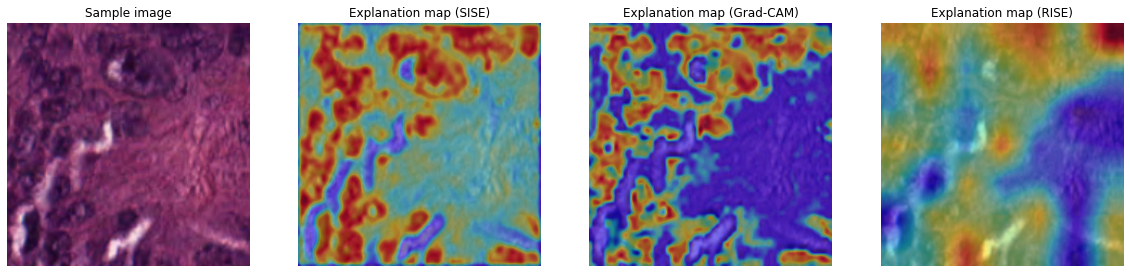

In [19]:
#@title Plot the results

plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Sample image')

plt.subplot(1,4,2)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_SISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (SISE)')

plt.subplot(1,4,3)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM)')

plt.subplot(1,4,4)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_RISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (RISE)')

## Quantitative evaluation of the explanation algorithm

In [20]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

## Part 2: Histopathological tissue classification

### Task \#3: Biomedical image classification and interpretation

#### 3.1.a: Overall classification accuracy on the test set

In [21]:
test_generator.reset()
y_test = []
y_pred = []
probs = []
counter = 0
while counter < 496:
  image_batch,label_batch = test_generator.next()
  prediction = model.predict(image_batch)
  pred_index = np.argmax(prediction, axis=1)
  true_index = np.argmax(label_batch, axis=1)
  
  y_test.extend([classes[i] for i in true_index])
  y_pred.extend([classes[i] for i in pred_index])
  probs.extend(prediction)
  counter += 32
y_test = np.array(y_test)
y_pred = np.array(y_pred)
probs = np.array(probs)

In [22]:
print('Overall classification Test Accuracy:', metrics.accuracy_score(y_test, y_pred))

Overall classification Test Accuracy: 0.8346774193548387


#### 3.1.b: Class-wise classification accuracy for all classes

In [23]:
m = metrics.confusion_matrix(y_test, y_pred)
class_wise_acc = m.diagonal() / m.sum(axis=1)

In [24]:
print('Class-wise classification accuracy on test set\n')
for i in range(len(classes)):
  print('Class',classes[i],'accuracy:',class_wise_acc[i],'\n')

Class-wise classification accuracy on test set

Class Tumor accuracy: 0.9516129032258065 

Class Stroma accuracy: 0.7741935483870968 

Class Complex accuracy: 0.6612903225806451 

Class Lympho accuracy: 1.0 

Class Debris accuracy: 0.8548387096774194 

Class Mucosa accuracy: 0.8225806451612904 

Class Adiopse accuracy: 0.7580645161290323 

Class Empty accuracy: 0.8548387096774194 



#### 3.1.c: ROC & AUC curves for each class

Note: The blue curve represents the ROC curve and the light pink region is the AUC, the area under the ROC curve.

AUC score for class Tumor : 0.9944626133491898
AUC score for class Stroma : 0.9584881819533224
AUC score for class Complex : 0.9655492790248253
AUC score for class Lympho : 0.9864724245577523
AUC score for class Debris : 0.9751003419057529
AUC score for class Mucosa : 0.9919726475397651
AUC score for class Adiopse : 0.9996655269808236
AUC score for class Empty : 0.9997398543184183


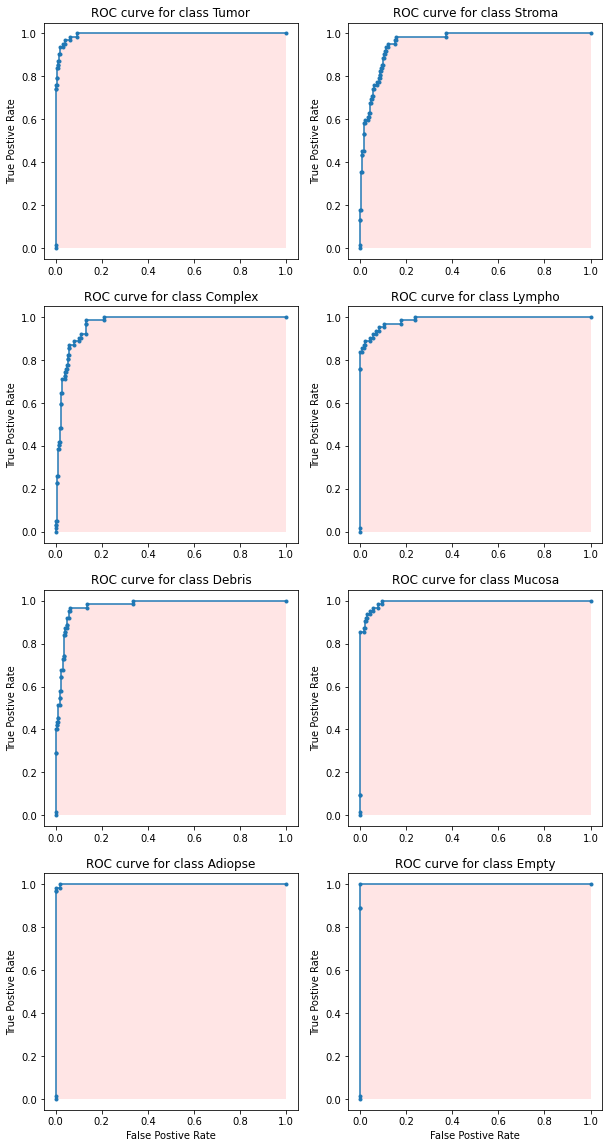

In [25]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,20))
for i in range(len(classes)):
  y_binary = y_test == classes[i]
  auc = metrics.roc_auc_score(y_binary, probs[:,i])
  print('AUC score for class',classes[i],':',auc)
  fpr, tpr, _ = metrics.roc_curve(y_binary, probs[:,i], pos_label=True)
  # Plot the ROC-AUC curve for each class
  axs[i//2,i%2].plot(fpr, tpr, marker='.')
  axs[i//2,i%2].set_title('ROC curve for class '+classes[i])
  if i//2 == 3:
    axs[i//2,i%2].set(xlabel='False Postive Rate')
  axs[i//2,i%2].set(ylabel='True Postive Rate')
  axs[i//2,i%2].fill_between(fpr, tpr,facecolor='red', alpha=.1)

#### 3.1.d: Plot the normalized confusion matrix

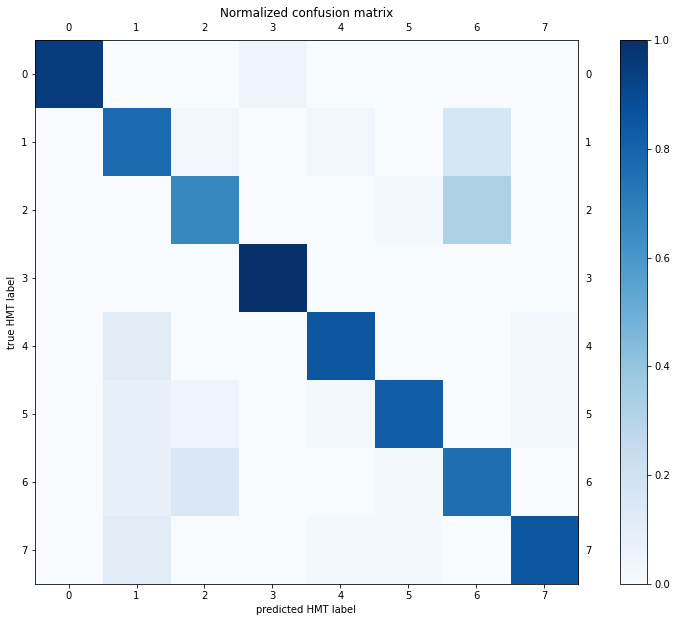

In [26]:
normalized_cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize = (15,10))
plt.imshow(normalized_cm, cmap=plt.cm.Blues)
plt.xlabel("predicted HMT label")
plt.ylabel("true HMT label")
plt.xticks(np.arange(8), labels=range(8), visible=True)
plt.yticks(np.arange(8), labels=range(8), visible=True)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.show()

#### 3.1.e: Precision, Recall, F-1 score on test set

In [27]:
print('Overall classification Test Precision:',metrics.precision_score(y_test, y_pred, average='micro'))
print('Overall classification Test Recall:',metrics.recall_score(y_test, y_pred, average='micro'))
print('Overall classification Test F-1:',metrics.f1_score(y_test, y_pred, average='micro'))

Overall classification Test Precision: 0.8346774193548387
Overall classification Test Recall: 0.8346774193548387
Overall classification Test F-1: 0.8346774193548387


#### 3.2: Ablation-CAM on HMT dataset

Implement the Ablation-CAM algorithm according to paper: https://openaccess.thecvf.com/content_WACV_2020/html/Desai_Ablation-CAM_Visual_Explanations_for_Deep_Convolutional_Network_via_Gradient-free_Localization_WACV_2020_paper.html

In [28]:
def ablation_cam(input_model, image, layer_name):
  cls = np.argmax(input_model.predict(image))
  # Activation score when feature map A_k is present
  activation_score = input_model.predict(image)[0][cls]
  
  # Retrieve the feature map A_k for the given layer_name 
  conv_output = input_model.get_layer(layer_name).output
  feedforward = keras.models.Model([input_model.input], [conv_output, input_model.output])
  ff_results = feedforward([image])
  A_k = ff_results[0] #(1,56,56,64)
  
  # Forward pass through the model to produce y_c when A_k is present
  y_c = np.array([activation_score]*A_k.shape[3]) #(56,)
  
  # Idea from paper: 
  # Ablate that layer's activation and maintain other activation layer to W_k^c.
  # Ablated the given layer's activation map
  layers = input_model.layers # 8
  layer_index = layers.index(input_model.get_layer(layer_name)) # 5
  pre_outputs = [layer.output for layer in layers[:layer_index]] # 5
  
  # model_1: produce activation scores before input to the given layer_name
  model_1 = keras.models.Model(inputs=input_model.input, outputs=pre_outputs)

  # Construct input and output for model_2
  model_2_input_shape = layers[layer_index].input.shape[1:] #(56,56,64)
  model_2_input = keras.Input(shape=model_2_input_shape)
  # Construct forward pass flow for model_2
  tmp = model_2_input
  layer_it = iter(layers[layer_index+1:])
  for _ in range(layer_index+1,len(layers)):
    tmp = next(layer_it)(tmp)
  
  # model_2: use above input and output to construct model_2 for classifying 
  # the activation signals from model_1 (i.e. remove layer_name's activation layer)
  model_2 = keras.models.Model(inputs=model_2_input, outputs=tmp)
  
  # List of activations score when feature map A_k is removed
  y_c_k = []
  # For each feature map A_k, remove it to compute y_c_k
  for i in range(64):
    activations = model_1.predict(image) # image:(1,224,224,3)
    # Ablate the activations of the given layer
    ac_np = activations[4] # ac_np:(1, 112, 112, 64)
    for j in range(112):
      for k in range(112):
        ac_np[0][j][k][i] = 0.0
    pred = model_2(ac_np)
    y_c_k.append(pred[0][cls])
  y_c_k = np.array(y_c_k)

  # Divide by y_c instead of ||A_k|| as per the paper
  weights = (y_c - y_c_k) / y_c # weights:(64,)
  # weighted linear combination of activation maps and corresponding weights
  cam = np.mean(A_k[0] * weights,axis=-1) # A_k[0]:(56, 56, 64)
  H,W= image.shape[1:3]
  cam = np.maximum(cam, 0)
  cam = zoom(cam,H/cam.shape[0])
  cam = cam / cam.max() 
  return cam

In [29]:
def plot_explanation_maps(model, image_batch, label_batch, index, classes):
  plt.figure(figsize=(20,5))

  plt.subplot(1,5,1)
  plt.imshow(image_batch[index])
  plt.axis('off')
  plt.title('Sample image')

  prediction = model(image_batch)
  print('True label: '+classes[np.argmax(label_batch[index])])
  print('Predicted label: '+classes[np.argmax(prediction[index])])
  print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
  
  # Ablation-CAM
  explanation_map_AbCAM = ablation_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
  explanation_map_AbCAM -= explanation_map_AbCAM.min()
  explanation_map_AbCAM /= explanation_map_AbCAM.max()+10e-30
  plt.subplot(1,5,2)
  plt.imshow(image_batch[index])
  plt.imshow(explanation_map_AbCAM, cmap='jet', alpha=0.5)
  plt.axis('off')
  plt.title('Explanation map (Ablation-CAM)')

  # SISE
  layers=[['conv2d_3']]
  explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
  explanation_map_SISE -= explanation_map_SISE.min()
  explanation_map_SISE /= explanation_map_SISE.max()+10e-30
  plt.subplot(1,5,3)
  plt.imshow(image_batch[index])
  plt.imshow(explanation_map_SISE, cmap='jet', alpha=0.5)
  plt.axis('off')
  plt.title('Explanation map (SISE)')

  # Grad-CAM
  explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
  explanation_map_GradCAM -= explanation_map_GradCAM.min()
  explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30
  plt.subplot(1,5,4)
  plt.imshow(image_batch[index])
  plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
  plt.axis('off')
  plt.title('Explanation map (Grad-CAM)')

  # RISE
  explanation_map_RISE = RISE(image_batch[index], model, class_index=np.argmax(prediction[index]) ,N_MASKS=1000)
  explanation_map_RISE -= explanation_map_RISE.min()
  explanation_map_RISE /= explanation_map_RISE.max()+10e-30
  plt.subplot(1,5,5)
  plt.imshow(image_batch[index])
  plt.imshow(explanation_map_RISE, cmap='jet', alpha=0.5)
  plt.axis('off')
  plt.title('Explanation map (RISE)')

True label: Tumor
Predicted label: Tumor
Confidence score for the correct label: 0.99954695


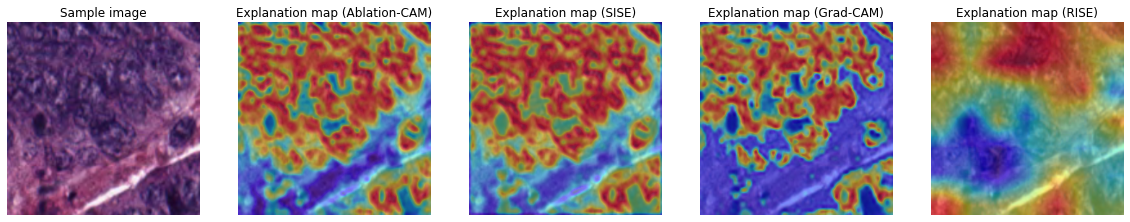

In [30]:
test_generator.reset()
image_batch, label_batch = test_generator.next()
plot_explanation_maps(model, image_batch, label_batch, 11, classes)

Choose the $12$th test image:

Four different explanation maps produced by the attribution methods are shown above. Comparing the Ablation-CAM with the others, in general, we can see that the highlighted regions in Ablation-CAM are pretty similar to those in SISE. If look closely, the Ablation-CAM is more contrast in the highlighted colors than the SISE especially in the bottom blue areas. The Grad-CAM highlights less regions comparing to Ablation-CAM and SISE, only a few salient parts are localized. Lastly, the RISE seems less useful as it only captures the top right tissue regions which is also vague. The other important parts are highlighted inaccurately in different colors. From this particular image, we can conclude that the Ablation-CAM methods improves the Grad-CAM by capturing more important features and maintaining the accuracy.

True label: Tumor
Predicted label: Mucosa
Confidence score for the correct label: 0.26127097


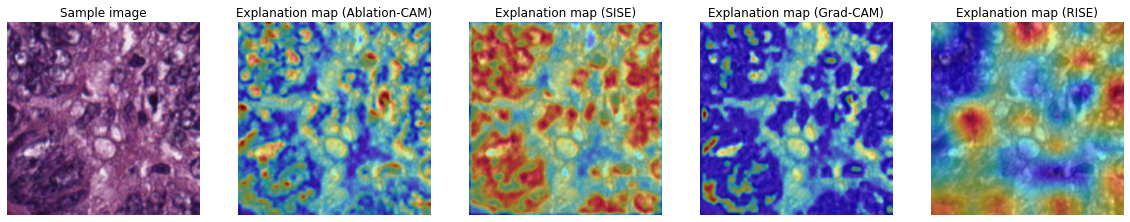

In [31]:
plot_explanation_maps(model, image_batch, label_batch, 15, classes)

Choose the $16$th test image:

In general, the quality of Ablation-CAM is sort of between SISE and Grad-CAM. We can see that SISE higlighted lots of important regions in red. Whereas, Grad-CAM highlighted them in mostly blue, green and yellow and only a few regions near the bottom left and top left in red. Ablation-CAM gives it a pretty nice balance between them. As it captures more important regions compared to Grad-CAM and highlighted them in less reddish color compared to SISE. Lastly, the RISE again gives an vague localization map by highlighting a few approximate regions in red.

True label: Tumor
Predicted label: Tumor
Confidence score for the correct label: 0.79107773


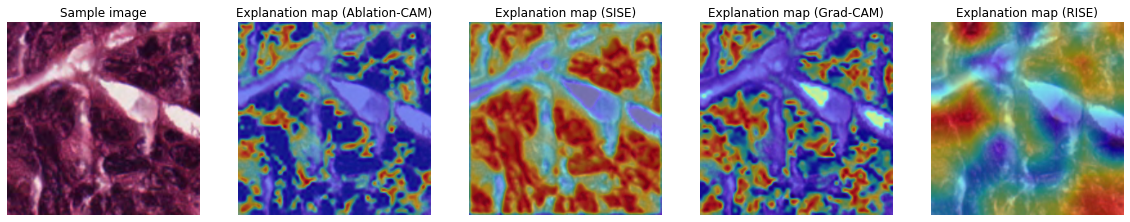

In [32]:
plot_explanation_maps(model, image_batch, label_batch, 20, classes)

Choose the $21$th test image:

Notice that the Ablation-CAM seems to capture less important regions comparing to SISE and Grad-CAM this time. Specifically, SISE captures the most important regions in red with comparsion to the sample image, it seems SISE almost localized those dark tissues in the sample image. Whereas, the Grad-CAM captures less those dark tissues and a notable white region in the middle. This might due the problem of gradient saturation when during back-propagation. The RISE again captures less informative regions and they are obviously vague.

### Task \#4: Quantitative evaluation of the attribution methods

#### 4.1: Drop% & Increase% on Ablation-CAM on HMT dataset

In [36]:
test_generator.reset()
drop_rate_AbCAM, incr_rate_AbCAM = 0., 0.
drop_rate_SISE, incr_rate_SISE = 0., 0.
drop_rate_GdCAM, incr_rate_GdCAM = 0., 0.
drop_rate_RI, incr_rate_RI = 0., 0.

for _ in range(15):
  image_batch,label_batch=test_generator.next()
  for index in range(32):
    prediction = model(image_batch)
    input2 = np.expand_dims(image_batch[index], axis=0)

    e_map_AbCAM = ablation_cam(model, input2, 'max_pooling2d_1')
    (drop_Ab, incr_Ab, Y_Ab, O1_Ab) = calculate_drop_increase(input2, model, e_map_AbCAM, class_index=np.argmax(prediction[index]), frac=0.9)
    drop_rate_AbCAM += drop_Ab
    incr_rate_AbCAM += incr_Ab

    e_map_SISE = SISE(input2, model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
    (drop_SI, incr_SI, Y_SI, O1_SI) = calculate_drop_increase(input2, model, e_map_SISE, class_index=np.argmax(prediction[index]), frac=0.9)
    drop_rate_SISE += drop_SI
    incr_rate_SISE += incr_SI

    e_map_GradCAM = grad_cam(model, input2, 'max_pooling2d_1')
    (drop_Gd, incr_Gd, Y_Gd, O1_Gd) = calculate_drop_increase(input2, model, e_map_GradCAM, class_index=np.argmax(prediction[index]), frac=0.9)
    drop_rate_GdCAM += drop_Gd
    incr_rate_GdCAM += incr_Gd

    e_map_RISE = RISE(image_batch[index], model, class_index=np.argmax(prediction[index]) ,N_MASKS=1000)
    (drop_RI, incr_RI, Y_RI, O1_RI) = calculate_drop_increase(input2, model, e_map_RISE, class_index=np.argmax(prediction[index]), frac=0.9)
    drop_rate_RI += drop_RI
    incr_rate_RI += incr_RI

drop_rate_AbCAM /= (15*32)
incr_rate_AbCAM /= (15*32)    

drop_rate_SISE /= (15*32)
incr_rate_SISE /= (15*32)

drop_rate_GdCAM /= (15*32)
incr_rate_GdCAM /= (15*32) 

drop_rate_RI /= (15*32)
incr_rate_RI /= (15*32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


In [37]:
print('k=0.9\n')
print('Ablation-CAM')
print('-Drop rate:',drop_rate_AbCAM,'\n-Increase rate:',incr_rate_AbCAM,'\n')

print('SISE')
print('-Drop rate:',drop_rate_SISE,'\n-Increase rate:',incr_rate_SISE,'\n')

print('Grad-CAM')
print('-Drop rate:',drop_rate_GdCAM,'\n-Increase rate:',incr_rate_GdCAM,'\n')

print('RISE')
print('-Drop rate:',drop_rate_RI,'\n-Increase rate:',incr_rate_RI,'\n')

k=0.9

Ablation-CAM
-Drop rate: 0.6188693819275267 
-Increase rate: 0.20416666666666666 

SISE
-Drop rate: 0.5977349694654244 
-Increase rate: 0.17916666666666667 

Grad-CAM
-Drop rate: 0.4893235019023988 
-Increase rate: 0.29583333333333334 

RISE
-Drop rate: 0.5218036429421329 
-Increase rate: 0.175 



#### 4.2: Discussion of Ablation-CAM on HMT dataset

From above, for Ablation-CAM, the average drop rate is $0.618$ and the average increase rate is $0.204$ on the whole test set given each input image retaining the top $90\%$ of the pixels. Comparing it with the other three methods, the lowest drop rate, $0.489$, is achieved by Grad-CAM and the highest increase rate, $0.295$, is also achieved by Grad-CAM. Notice that Ablation-CAM achieved the highest drop rate among them, this indicates that if $90\%$ most important pixels are retained and feed into the target model, the model confidence score will drop about $61.8\%$ on average, Ablation-CAM is more likely to miss some of important features and captures lots of unimportant features. That causes the target model having lower confidence score and effecting to make wrong predictions. On the other hand, Ablation-CAM achieved the second largest increase rate among them. It means if $10\%$ most misleading pixels are removed by Ablation-CAM, that causes the target model be more confident in its predictions given the refined images. After comparison, in conclusion, Ablation-CAM is not the most successful one in explaining the model's behavior on HMT dataset.

Cases where Ablation-CAM fails to explain the target model's prediction

In [33]:
def exp_pred(images, model, exmap, frac=0.15):
  img = images[0,:,:,:]
  img = img_to_array(img)
  img = np.expand_dims(img,axis=0)
    
  grad_array = np.reshape(exmap, (-1,))
  array_size = int(grad_array.shape[0]*frac)
  thr = np.flip(sorted(grad_array))[array_size]
  exmap1_msk = (exmap>thr)
  exmap1_thr = np.zeros(shape=(1,224,224,3))
  exmap1_thr[0,:,:,0] = img[0,:,:,0]*exmap1_msk
  exmap1_thr[0,:,:,1] = img[0,:,:,1]*exmap1_msk
  exmap1_thr[0,:,:,2] = img[0,:,:,2]*exmap1_msk

  ex_predictions = model.predict(exmap1_thr)[0]
  y_exp_index = np.argmax(ex_predictions)
  y_exp = classes[y_exp_index]
  y_exp_confidence = ex_predictions[y_exp_index]
  
  return y_exp, y_exp_confidence

In [88]:
idx = 5
test_generator.reset()
image_batch, label_batch = test_generator.next()

y_true = classes[np.argmax(label_batch[idx])]

prediction = model(image_batch)
y_index = np.argmax(prediction[idx])
y = classes[y_index]
y_confidence = float(prediction[idx][y_index])

input = np.expand_dims(image_batch[idx], axis=0)
expln_map_AbCAM = ablation_cam(model, input, 'max_pooling2d_1')
y_exp, y_exp_confidence = exp_pred(input, model, expln_map_AbCAM, frac=0.9)

In [89]:
print('Ablation-CAM')
print('True label:', y_true, '\nImage index:',idx)
print('\nComplete input')
print('- Prediction:', y,'\n- Confidence score:', y_confidence)
print('\nExplanation map processed input')
print('- Prediction:', y_exp, '\n- Confidence score:', y_exp_confidence)

Ablation-CAM
True label: Tumor 
Image index: 5

Complete input
- Prediction: Tumor 
- Confidence score: 0.9755038022994995

Explanation map processed input
- Prediction: Lympho 
- Confidence score: 0.80272365


In [90]:
expln_map_GradCAM = grad_cam(model, input, 'max_pooling2d_1')
y_exp_gr, y_exp_confidence_gr = exp_pred(input, model, expln_map_GradCAM, frac=0.9)

print('Grad-CAM')
print('True label:', y_true, '\nImage index:',idx)
print('\nComplete input')
print('- Prediction:', y,'\n- Confidence score:', y_confidence)
print('\nExplanation map processed input')
print('- Prediction:', y_exp_gr, '\n- Confidence score:', y_exp_confidence_gr)

Grad-CAM
True label: Tumor 
Image index: 5

Complete input
- Prediction: Tumor 
- Confidence score: 0.9755038022994995

Explanation map processed input
- Prediction: Tumor 
- Confidence score: 0.96629304


True label: Tumor
Predicted label: Tumor
Confidence score for the correct label: 0.9755038


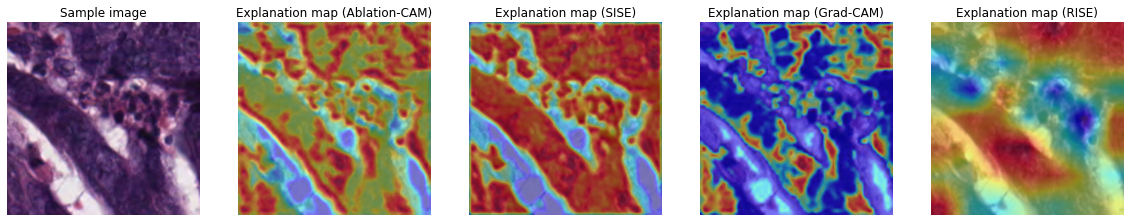

In [91]:
test_generator.reset()
image_batch, label_batch = test_generator.next()
plot_explanation_maps(model, image_batch, label_batch, idx, classes)

From above outputs and figures, we can conclude, for image at index 5, the target model with a complete input correctly predicts it as 'Tumor' with a confidence score $97.5\%$. After removed the $10\%$ most misleading features from the input image by Ablation-CAM, the target model fails and predicts it as 'Lympho' with a confidence score $80.2\%$. However, using Grad-CAM on input image, the target model successfully make correct prediction with a confidence score $96.6\%$ which is pretty close to the true model confidence score. This indicates that lots of unimportant features are maintained by Ablation-CAM and more key features are maintained by Grad-CAM. From the visualization of explanation maps, it is clear to see there are more reddish regions highlighted in Ablation-CAM than Grad-CAM. Thus, more unimportant features are more likely to be maintained which would possibly trick the model to make wrong prediction.